# Supply Chain Analysis

Supply chain management is the process of planning, organizing, and controlling the flow of goods and services from suppliers to customers. Among many benefits such analysis provides, we can mention a few:
- *improvement in efficiency* - by optimizing the flow of goods and services, supply chain management can help businesses to reduce waste and improve productivity;
- *increased customer satisfaction* -by ensuring that products are available when and where customers need them, supply chain management can help businesses to improve customer satisfaction;
- *profit increase* - by making the customers happier with the service and optimal workflow, supply chain management can generate less cost and drive sales.

In this analysis we will take a look at company DataCo Group, fictional company, but insight from this analysis might be forwarded into real life problems and instances. The dataset comes from [this](https://www.kaggle.com/datasets/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis) page on Kaggle. Also as a person working somewhere near Supply Chains (I have experience in Order Processing and Content Management), I am excited to learn more about it.

## How is this analysis useful?
Although these data describe a made-up company, the insights and techniques used in this analysis can be used for any supply chain analysis. 

In the upcoming analysis, I will focus on my two main objectives:
- **Objective 1** - find out what works good for DataCo Global, what does not and looks weird - give data informed insight on the company, it's strong points and points to change;
- **Objective 2** - perform an ABC Analysis, to define the most profitable, most important products in the DataCo Group portfolio and suggest how to leverage this finding;
- **Objective 3** - draw conclusions, why the sales are down, or why perhaps this company had to forclose, based solenly on the data in this study and some of my experience.

In this analysis I will also be using `Tableau` as my visualization tool, more so than visualize data in the notebook. If you want to check out my dashboards right now, feel free to explote [my Tableau Public](https://public.tableau.com/app/profile/truposzeq/vizzes), all files related to thi analysis are titled *Supply_Chain_Analysis_Dashboard_{number}*. I will also mention dashboards as I go with my findings.

# Imports

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from datetime import datetime
import pickle
import dataframe_image as dfi
from translate import Translator
from sca_functions import (outliers, extended_describe, count_orders,
                           count_items_ordered)


pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

with open('data/supply_chain_dictionaties.pkl', 'rb') as file:
    dictionaries = pickle.load(file)

product_name = dictionaries[0]
department_name = dictionaries[1]
category_name = dictionaries[2]

In [3]:
df = pd.read_parquet('data/SupplyChainDataset_cleaned.parquet')
df['Order_time'] = df['Order_date'].dt.time
df['Shipping_time'] = df['Shipping_date'].dt.time
df['Shipping_date'] = df['Shipping_date'].dt.date
df['Order_date'] = df['Order_date'].dt.date
df.head()

,Type,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Id,Customer_Segment,Customer_State,Department_Id,Market,Order_Country,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Region,Order_Status,Product_Card_Id,Product_Price,Shipping_Mode,Shipping_date,Order_date,Order_time,Order_day,Shipping_time,Shipping_day,Target_shipping_days
0,CASH,88.79,239.98,0,43,Hickory,United States,11599,Consumer,NC,7,LATAM,México,1,60.00,0.20,1,0.37,1,299.98,Central America,CLOSED,957,299.98,Standard Class,2015-03-01,2015-01-01,00:00:00,Thursday,00:00:00,Sunday,-2
1,PAYMENT,36.47,107.89,0,18,Chicago,United States,256,Consumer,IL,4,LATAM,Colombia,2,22.10,0.17,4,0.34,1,129.99,South America,PENDING_PAYMENT,403,129.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
2,PAYMENT,91.18,193.99,0,48,Chicago,United States,256,Consumer,IL,7,LATAM,Colombia,2,6.00,0.03,2,0.47,1,199.99,South America,PENDING_PAYMENT,1073,199.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
3,PAYMENT,68.25,227.50,0,24,Chicago,United States,256,Consumer,IL,5,LATAM,Colombia,2,22.50,0.09,3,0.30,5,250.00,South America,PENDING_PAYMENT,502,50.00,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
4,PAYMENT,19.80,90.00,1,24,Conway,United States,10039,Consumer,AR,5,LATAM,Honduras,30,10.00,0.10,88,0.22,2,100.00,Central America,PENDING_PAYMENT,502,50.00,Standard Class,2015-07-01,2015-01-01,10:09:00,Thursday,10:09:00,Wednesday,2


In [22]:
# tu będą moje funkcje zabrane na koniec
from mtranslate import translate

df['Order_Country'] = df['Order_Country'].astype(str)

countries = df['Order_Country'].unique()
countries_eng = {}

for country in countries:
    if country not in countries_eng.keys():
        countries_eng[country] = translate(country, 'en')

df['Order_Country'] = df['Order_Country'].map(countries_eng)
df.head()

,Type,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Id,Customer_Segment,Customer_State,Department_Id,Market,Order_Country,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Region,Order_Status,Product_Card_Id,Product_Price,Shipping_Mode,Shipping_date,Order_date,Order_time,Order_day,Shipping_time,Shipping_day,Target_shipping_days
0,CASH,88.79,239.98,0,43,Hickory,United States,11599,Consumer,NC,7,LATAM,Mexico,1,60.00,0.20,1,0.37,1,299.98,Central America,CLOSED,957,299.98,Standard Class,2015-03-01,2015-01-01,00:00:00,Thursday,00:00:00,Sunday,-2
1,PAYMENT,36.47,107.89,0,18,Chicago,United States,256,Consumer,IL,4,LATAM,Colombia,2,22.10,0.17,4,0.34,1,129.99,South America,PENDING_PAYMENT,403,129.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
2,PAYMENT,91.18,193.99,0,48,Chicago,United States,256,Consumer,IL,7,LATAM,Colombia,2,6.00,0.03,2,0.47,1,199.99,South America,PENDING_PAYMENT,1073,199.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
3,PAYMENT,68.25,227.50,0,24,Chicago,United States,256,Consumer,IL,5,LATAM,Colombia,2,22.50,0.09,3,0.30,5,250.00,South America,PENDING_PAYMENT,502,50.00,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
4,PAYMENT,19.80,90.00,1,24,Conway,United States,10039,Consumer,AR,5,LATAM,Honduras,30,10.00,0.10,88,0.22,2,100.00,Central America,PENDING_PAYMENT,502,50.00,Standard Class,2015-07-01,2015-01-01,10:09:00,Thursday,10:09:00,Wednesday,2


# Exploratory Data Analysis
## Objective 1 : give data oriented insight on the DataCo Global business situation.

In this part of the analysis I want to take a better look at the DataCo Global business situation. I will tahe a look on the data and with initial analysis try to find business problems. Then I will recognize some questions and answer them by modifying the data. 

This part will not include ABC analys, that is not answer which product bring in the most revenue and which are not essencial for DataCo Global. 

I will answer all of these question in this notebook and portray most of them in Tableau dashboards. I will also provide some simple visualizations in this notebook, for better understanding of data. I already did this with the whole dataset before I cleaned it and I was able to choore the columns that interest me the most. 

Let's see the how this dataset looks like.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Type                      180519 non-null  category
 1   Benefit_per_order         180519 non-null  float64 
 2   Sales_per_customer        180519 non-null  float64 
 3   Late_delivery_risk        180519 non-null  int64   
 4   Category_Id               180519 non-null  category
 5   Customer_City             180519 non-null  object  
 6   Customer_Country          180519 non-null  category
 7   Customer_Id               180519 non-null  category
 8   Customer_Segment          180519 non-null  category
 9   Customer_State            180519 non-null  object  
 10  Department_Id             180519 non-null  category
 11  Market                    180519 non-null  category
 12  Order_Country             180519 non-null  object  
 13  Order_Id                  180

In [39]:
df.shape

(180519, 32)

In [3]:
df.columns

Index(['Type', 'Benefit_per_order', 'Sales_per_customer', 'Late_delivery_risk',
       'Category_Id', 'Customer_City', 'Customer_Country', 'Customer_Id',
       'Customer_Segment', 'Customer_State', 'Department_Id', 'Market',
       'Order_Country', 'Order_Id', 'Order_Item_Discount',
       'Order_Item_Discount_Rate', 'Order_Item_Id', 'Order_Item_Profit_Ratio',
       'Order_Item_Quantity', 'Sales', 'Order_Region', 'Order_Status',
       'Product_Card_Id', 'Product_Price', 'Shipping_Mode', 'Shipping_date',
       'Order_date', 'Order_time', 'Order_day', 'Shipping_time',
       'Shipping_day', 'Target_shipping_days'],
      dtype='object')

In [38]:
df.describe()

,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Product_Price,Target_shipping_days
count,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00
mean,21.97,183.11,0.55,20.66,0.10,0.12,2.13,203.77,141.23,0.57
std,104.43,120.04,0.50,21.80,0.07,0.47,1.45,132.27,139.73,1.49
min,-4274.98,7.49,0.00,0.00,0.00,-2.75,1.00,9.99,9.99,-2.00
25%,7.00,104.38,0.00,5.40,0.04,0.08,1.00,119.98,50.00,0.00
50%,31.52,163.99,1.00,14.00,0.10,0.27,1.00,199.92,59.99,1.00
75%,64.80,247.40,1.00,29.99,0.16,0.36,3.00,299.95,199.99,1.00
max,911.80,1939.99,1.00,500.00,0.25,0.50,5.00,1999.99,1999.99,4.00


In [40]:
df.isnull().sum().sum()

0

In [41]:
df.duplicated().sum()

0

## Numerical (and categorical) data analysis


In [24]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

continous_columns = ['Benefit_per_order', 'Sales_per_customer','Order_Item_Discount',
                     'Order_Item_Profit_Ratio', 'Sales', 'Product_Price']

In [26]:
ext_stat_continuous = extended_describe(df, continous_columns)
dfi.export(ext_stat_continuous,"graphs/others/Continous_ext_stats.png")
ext_stat_continuous

,Benefit_per_order,Sales_per_customer,Order_Item_Discount,Order_Item_Profit_Ratio,Sales,Product_Price
Mean,21.97,183.11,20.66,0.12,203.77,141.23
Standard deviation,104.43,120.04,21.80,0.47,132.27,139.73
Median,31.52,163.99,14.00,0.27,199.92,59.99
Sum,3966902.97,33054402.04,3730378.40,21779.01,36784735.01,25495158.68
Skewness,-4.74,2.89,3.04,-2.89,2.88,3.19
Kurtosis,71.38,23.92,25.23,10.16,23.94,23.31
Outliers count,18942.00,1943.00,7537.00,17300.00,488.00,2048.00
IQR Lower bound,-79.70,-110.15,-31.48,-0.34,-149.98,-174.99
IQR Upper bound,151.50,461.93,66.87,0.78,569.91,424.98


extended_statistics(df, numeric_columns)

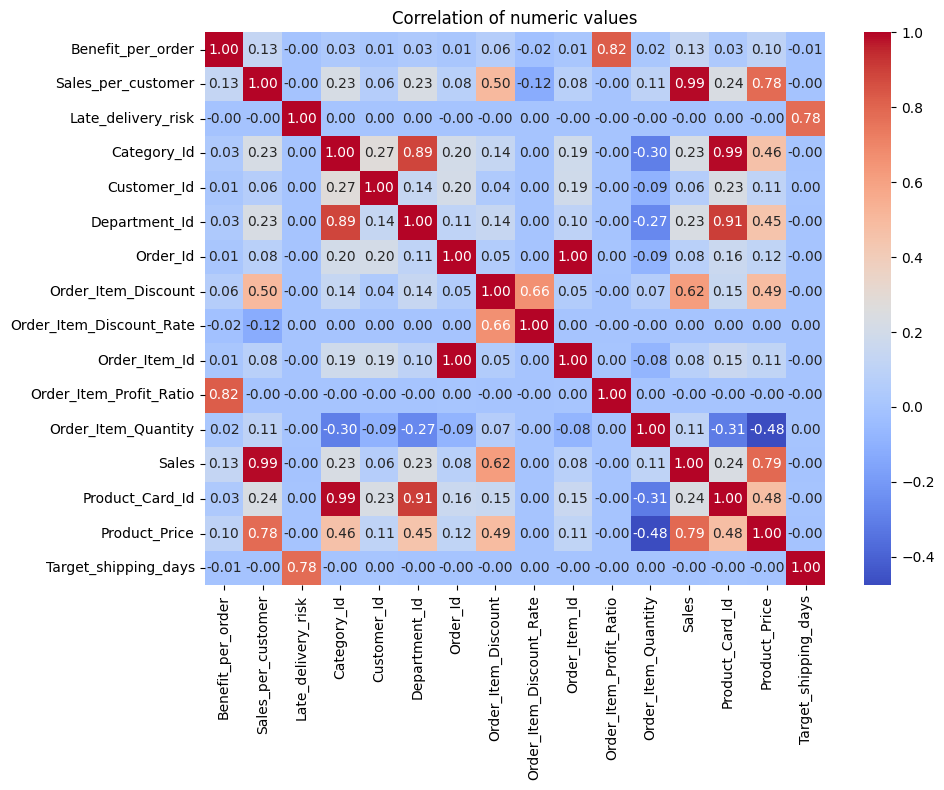

In [28]:
corr = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=',.2f')
plt.title('Correlation of numeric values')
plt.tight_layout()
plt.savefig(f'graphs/others/Correlogram_of_numeric_values.png')

plt.show()

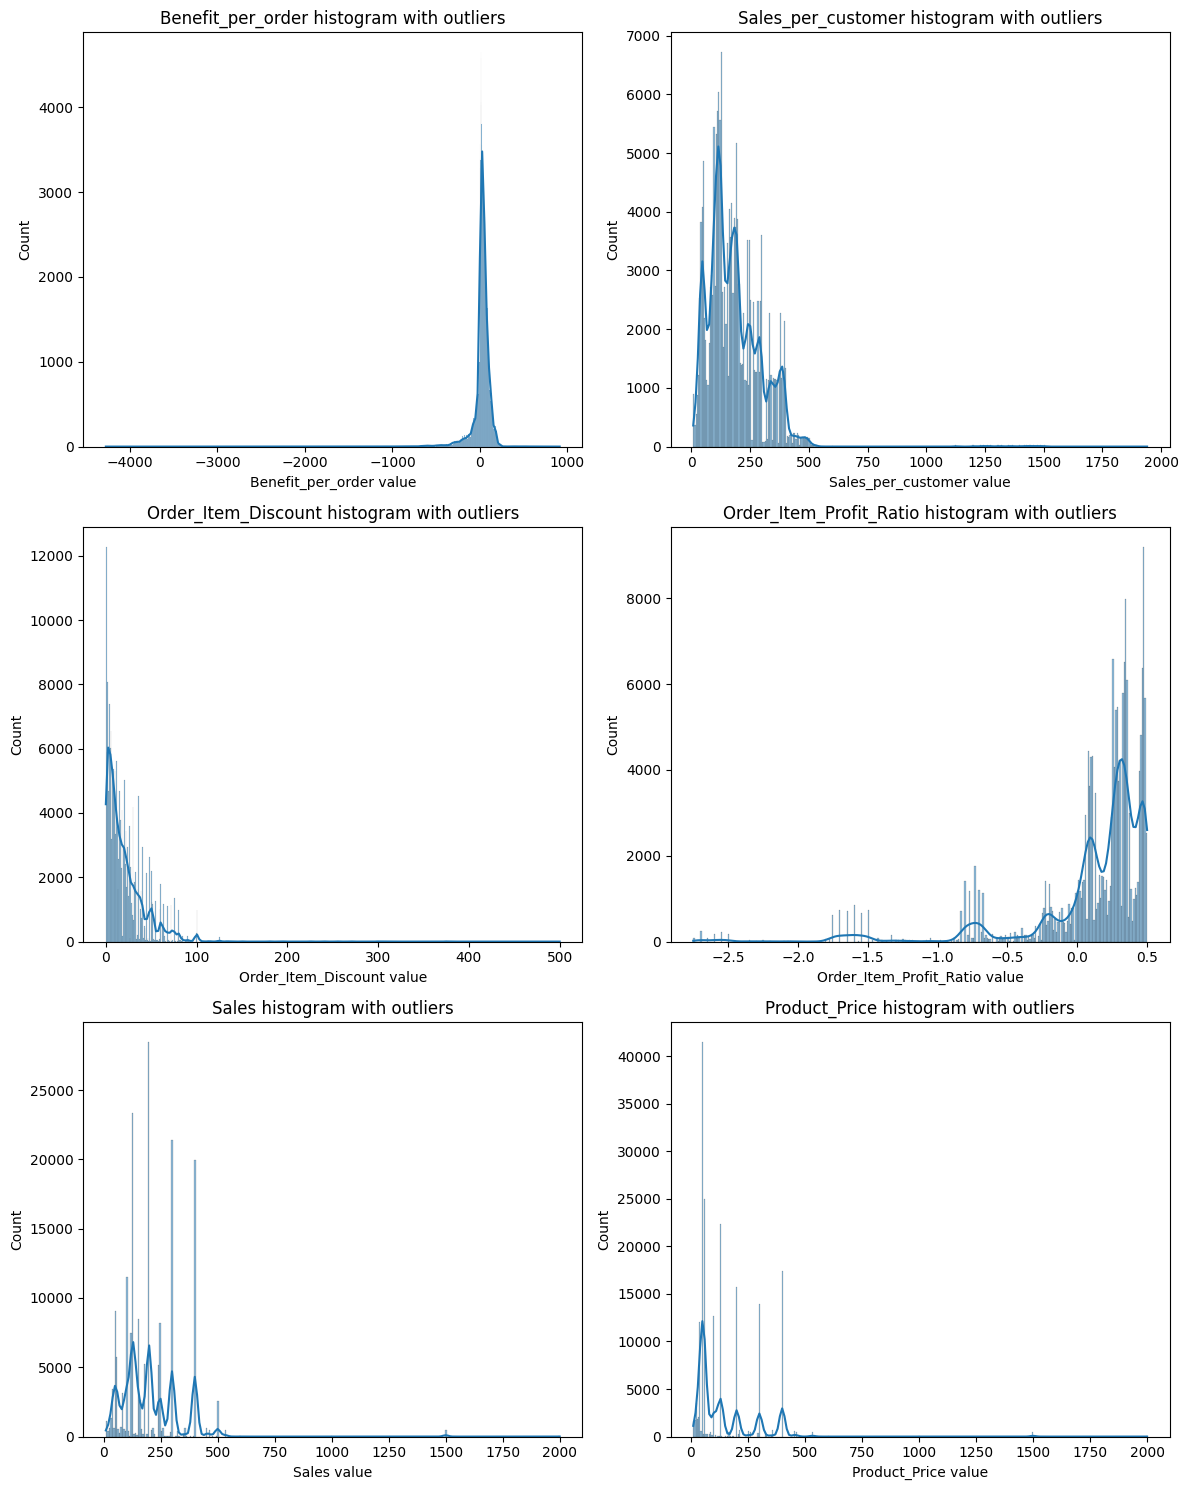

In [31]:
num_rows = len(continous_columns) // 2
if len(continous_columns) % 2 == 0:
    num_cols = 2
else:
    num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))

if num_rows == 1:
    axes = [axes]

for i, c in enumerate(continous_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    sns.histplot(data=df, x=c, kde=True, ax=ax)
    ax.set_title(f'{c} histogram with outliers')
    ax.set_xlabel(f'{c} value')
    ax.set_ylabel('Count')

    if num_rows == 1:
        axes[1].axis('off')

if len(continous_columns) % 2 == 1:
    axes[-1][-1].axis('off')

plt.tight_layout()
plt.show()

Outliers in this dataset should not be deleted or replaced, as these are calculated correctly - our store has a few more pricey items, hence some of the higher sales, and since not all items in the store are profitable, we notice the negative benefits or profit ratios. These outliers give us a great information, at where we are losing money in the supply chain, since the benefits are greatly negative in those instances.

However, those orders are minority. I will create an additional dataset to get the look at majority of the data and then compare the majority distribution with the one with outliers. Later on in the analysis, we will take a look at those outliers to analyse, which products should be withdrawn from the offer, to avoid further losses.

In [32]:
outliers_in_columns = {}
for c in continous_columns:
    outliers_in_columns[c] = outliers(df, c)[0]

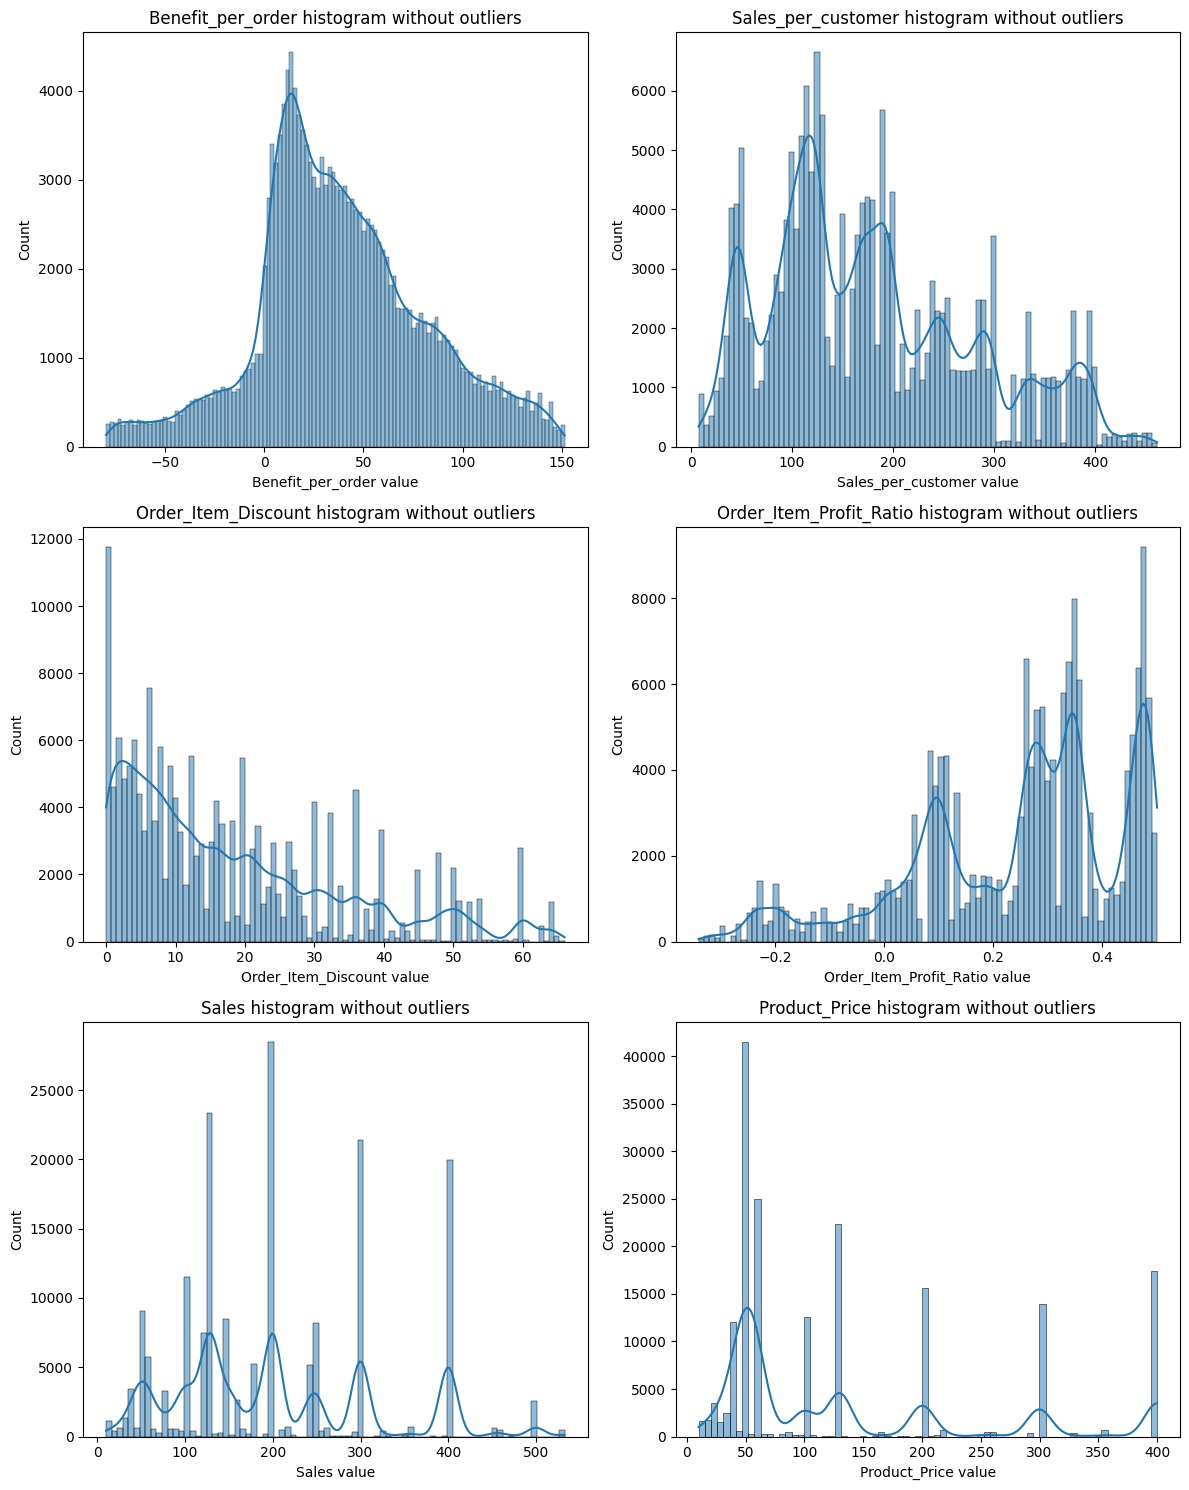

In [36]:
num_rows = len(continous_columns) // 2
if len(continous_columns) % 2 == 0:
    num_cols = 2
else:
    num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5*num_rows))

if num_rows == 1:
    axes = [axes]

for i, c in enumerate(continous_columns):
    filtered_df = df.drop(df[df[c].isin(outliers_in_columns[c])].index)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    sns.histplot(data=filtered_df, x=c, kde=True, ax=ax)
    ax.set_title(f'{c} histogram without outliers')
    ax.set_xlabel(f'{c} value')
    ax.set_ylabel('Count')

    if num_rows == 1:
        axes[1].axis('off')

if len(continous_columns) % 2 == 1:
    axes[-1][-1].axis('off')

plt.tight_layout()
plt.show()

**zlicz wszystkie wartości kategorii**
`df['name'].value_counts(ascending=False)`

może zbierz te, które mają mniejsze wartości niż ileś (średnia?) jako inne
`df[].apply(funkcja)`

jak znajdziesz ile zamawia się jakich produktów, wskaż top 5 i najgorsze 5 pod względem zysków i częstości wybierania
(pewnie da się to zrobić przez group by średnią albo count?)

pousuwać outliersy ale gdy zliczymy zamówienia? czy nje?

korelogram

zyski odnotowane ze sprzedaży na dzień, dla szeregu czasowego (to przy szeregach) 
lub liczba zamówień, albo oba

sprawdzić błądzenie losowe i whitenoise dla szeregu czasowego (zyski lub liczba zamówień)

czy są jakieś przesłanki dla opóźnionej wysyłki?
(klastrowanie?)

ABC analysis??co to??

## Zliczenie zamówień dla danych kategorycznych

In [ ]:
product_orders = count_orders(df, 'Product_Card_Id', product_name)
product_items_ordered = count_items_ordered(df, 'Product_Card_Id', product_name)

categories_orders = count_orders(df, 'Category_Id', category_name)
categories_items_ordered = count_items_ordered(df, 'Category_Id', category_name)

department_orders = count_orders(df, 'Department_Id', department_name)
department_items_ordered = count_items_ordered(df, 'Department_Id', department_name)

In [ ]:
product_df = pd.DataFrame(product_orders)
product_df['Items_sold'] = product_items_ordered
product_df

,Product_Card_Id,Items_sold
Perfect Fitness Perfect Rip Deck,24515,73698
Nike Men's CJ Elite 2 TD Football Cleat,22246,22246
Nike Men's Dri-FIT Victory Golf Polo,21035,62956
O'Brien Men's Neoprene Life Vest,19298,57803
Field & Stream Sportsman 16 Gun Fire Safe,17325,17325
...,...,...
Stiga Master Series ST3100 Competition Indoor,27,27
SOLE E35 Elliptical,15,15
Bushnell Pro X7 Jolt Slope Rangefinder,11,11
Bowflex SelectTech 1090 Dumbbells,10,10


In [75]:
department_orders

Fan Shop              66861
Apparel               48998
Golf                  33220
Footwear              14525
Outdoors               9686
Fitness                2479
Discs Shop             2026
Technology             1465
Pet Shop                492
Book Shop               405
Health and Beauty       362
Name: Department_Id, dtype: int64

## Plotting bars

In [40]:
barplots = ['Shipping_day', 'Order_day', 'Order_Status', 
            'Target_shipping_days', 'Late_delivery_risk', 'Type', 
            'Customer_Country', 'Customer_Segment', 'Shipping_Mode']

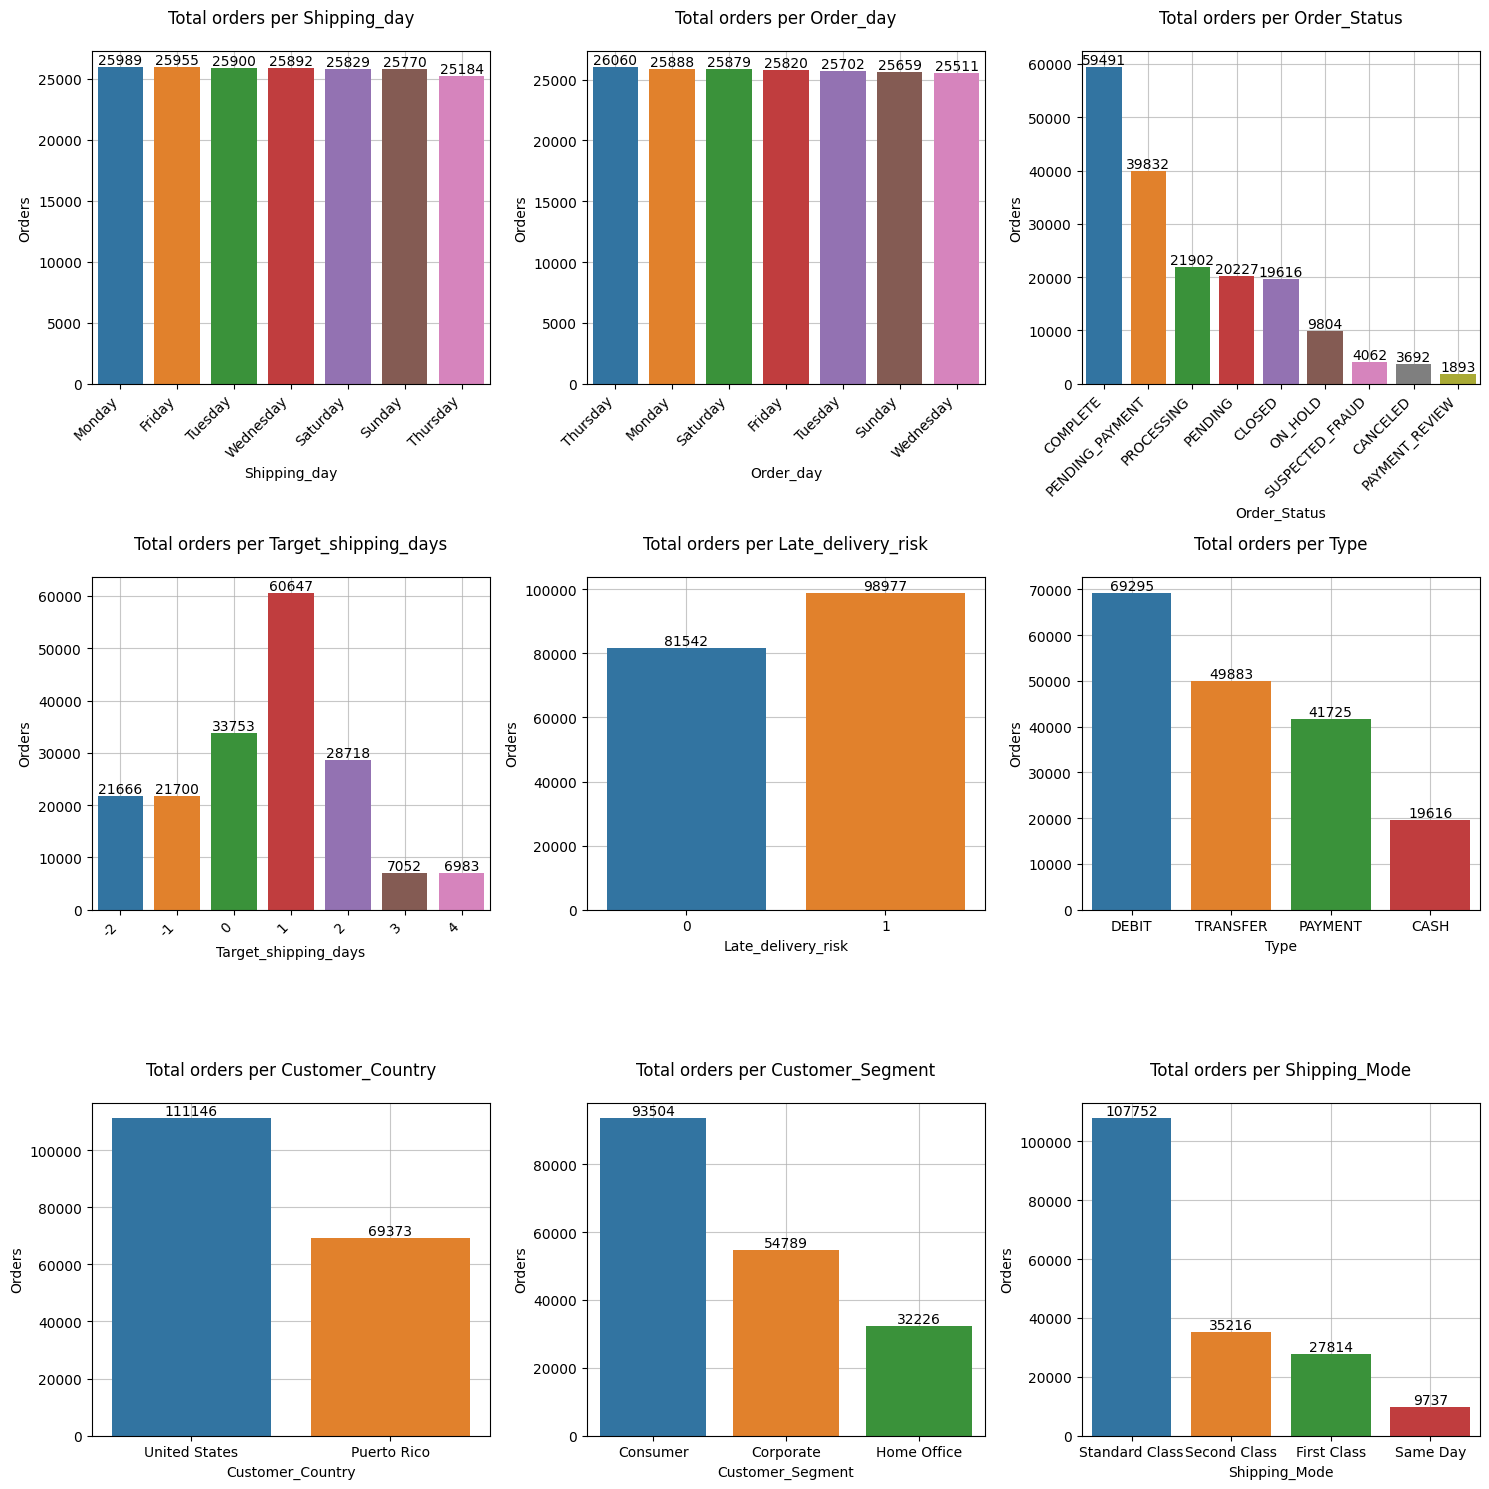

In [57]:
num_rows = len(barplots) // 3
if len(barplots) % 3 == 0:
    num_cols = 3
else:
    num_cols = 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

if num_rows == 1:
    axes = [axes]

for i, c in enumerate(barplots):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]

    orders = count_orders(df, c)
            
    sns.barplot(x=orders.index, y=orders, ax=ax)
    ax.bar_label(ax.containers[0])
    ax.set_title(f'Total orders per {c}', pad=20)
        
    ax.set_xlabel(f'{c}')
    ax.set_ylabel('Orders')
    if len(orders) >= 7:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_axisbelow(True)
    ax.grid(alpha=0.7)

    if num_rows == 1:
        axes[1].axis('off')

if len(barplots) % 3 == 1:
    axes[-1][-1].axis('off')

plt.tight_layout()
plt.show()

In [73]:
fraud_per_dep = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Department_Id') \
                .size().sort_values(ascending=False) / df.groupby('Department_Id').size()

fraud_per_dep.index = fraud_per_dep.index.map(department_name)

fraud_count_per_dep = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Department_Id').size()

fraud_count_per_dep.index = fraud_count_per_dep.index.map(department_name)

#dodaj value_counts()

fraud_info_per_dep = pd.DataFrame({
    'Fraud_Proportion': fraud_per_dep,
    'Fraud_Count': fraud_count_per_dep
})

fraud_info_per_dep

,Fraud_Proportion,Fraud_Count
Department_Id,,
Fitness,0.02,54
Footwear,0.02,328
Apparel,0.02,1127
Golf,0.02,744
Outdoors,0.02,222
Fan Shop,0.02,1483
Book Shop,0.03,11
Discs Shop,0.02,39
Technology,0.02,32


In [114]:
most_losses = df.groupby('Product_Card_Id').agg({'Department_Id': 'unique',
                                                 'Benefit_per_order': 'mean'}).sort_values(by='Benefit_per_order')
most_losses.index = most_losses.index.map(product_name)
most_losses

,Department_Id,Benefit_per_order
Product_Card_Id,,
SOLE E35 Elliptical,"[3] Categories (11, int64): [2, 3, 4, 5, ..., ...",-64.34
Bushnell Pro X7 Jolt Slope Rangefinder,"[6] Categories (11, int64): [2, 3, 4, 5, ..., ...",-23.27
SOLE E25 Elliptical,"[2] Categories (11, int64): [2, 3, 4, 5, ..., ...",-16.96
CDs of rock,"[9] Categories (11, int64): [2, 3, 4, 5, ..., ...",1.42
Toys,"[7] Categories (11, int64): [2, 3, 4, 5, ..., ...",1.70
...,...,...
Polar FT4 Heart Rate Monitor,"[6] Categories (11, int64): [2, 3, 4, 5, ..., ...",57.95
Diamondback Boys' Insight 24 Performance Hybr,"[2] Categories (11, int64): [2, 3, 4, 5, ..., ...",59.68
Lawn mower,"[6] Categories (11, int64): [2, 3, 4, 5, ..., ...",69.10


In [ ]:
# plot discount vs. profit
# discount vs. sales
# discount vs. items ordered

,Type,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Id,Customer_Segment,Customer_State,Department_Id,Market,Order_Country,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Region,Order_Status,Product_Card_Id,Product_Price,Shipping_Mode,Shipping_date,Order_date,Order_time,Order_day,Shipping_time,Shipping_day,Target_shipping_days
95909,DEBIT,56.06,179.10,0,38,Caguas,Puerto Rico,10847,Consumer,PR,6,LATAM,Peru,57933,19.90,0.10,144942,0.31,1,199.00,South America,COMPLETE,305,199.00,Standard Class,2017-04-29,2017-04-25,16:09:00,Tuesday,16:09:00,Saturday,0
96414,CASH,47.08,181.09,1,38,Caguas,Puerto Rico,1493,Consumer,PR,6,LATAM,Honduras,58004,17.91,0.09,145131,0.26,1,199.00,Central America,CLOSED,305,199.00,Standard Class,2017-01-05,2017-04-26,17:02:00,Wednesday,17:02:00,Thursday,1
97439,DEBIT,62.55,185.07,1,38,Caguas,Puerto Rico,8346,Corporate,PR,6,LATAM,Cuba,58155,13.93,0.07,145516,0.34,1,199.00,Caribbean,COMPLETE,305,199.00,Standard Class,2017-04-05,2017-04-28,21:56:00,Friday,21:56:00,Wednesday,2
102583,DEBIT,65.82,188.06,1,38,Saint Charles,United States,7310,Consumer,MO,6,LATAM,Honduras,58321,10.95,0.06,145950,0.35,1,199.00,Central America,ON_HOLD,305,199.00,First Class,2017-03-05,2017-01-05,08:05:00,Thursday,08:05:00,Sunday,1
102975,TRANSFER,37.81,199.00,1,38,Caguas,Puerto Rico,3147,Corporate,PR,6,LATAM,Mexico,58969,0.00,0.00,147616,0.19,1,199.00,Central America,PENDING,305,199.00,Standard Class,2017-05-15,2017-10-05,19:07:00,Thursday,19:07:00,Monday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179450,PAYMENT,17.34,197.01,0,38,Caguas,Puerto Rico,412,Home Office,PR,6,Europe,United Kingdom,67147,1.99,0.01,167836,0.09,1,199.00,Northern Europe,PAYMENT_REVIEW,305,199.00,Standard Class,2017-10-09,2017-07-09,04:14:00,Sunday,04:14:00,Monday,-1
179844,DEBIT,14.01,159.20,1,38,Caguas,Puerto Rico,10185,Home Office,PR,6,Europe,Italia,67235,39.80,0.20,168049,0.09,1,199.00,Southern Europe,COMPLETE,305,199.00,Standard Class,2017-09-14,2017-08-09,11:03:00,Wednesday,11:03:00,Thursday,2
179949,DEBIT,51.74,199.00,1,38,Garland,United States,3887,Consumer,TX,6,Europe,Netherlands,67218,0.00,0.00,167997,0.26,1,199.00,Western Europe,COMPLETE,305,199.00,Second Class,2017-12-09,2017-08-09,05:06:00,Wednesday,05:06:00,Saturday,2
179975,DEBIT,74.63,149.25,0,38,Elmhurst,United States,10838,Consumer,NY,6,Europe,Austria,67227,49.75,0.25,168022,0.50,1,199.00,Western Europe,COMPLETE,305,199.00,Standard Class,2017-11-09,2017-08-09,08:15:00,Wednesday,08:15:00,Thursday,-1


In [109]:
df.head(1)

,Type,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Id,Customer_Segment,Customer_State,Department_Id,Market,Order_Country,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Region,Order_Status,Product_Card_Id,Product_Price,Shipping_Mode,Shipping_date,Order_date,Order_time,Order_day,Shipping_time,Shipping_day,Target_shipping_days
0,CASH,88.79,239.98,0,43,Hickory,United States,11599,Consumer,NC,7,LATAM,México,1,60.00,0.20,1,0.37,1,299.98,Central America,CLOSED,957,299.98,Standard Class,2015-03-01,2015-01-01,00:00:00,Thursday,00:00:00,Sunday,-2



In this notebook we will take a dive into the costs and profits of all our orders. We will see, which products are the most profitable and which ones should, perhaps, be taken of the list.   
Among others, we will see:

- which product categories are most often cancelled or possibly fraudulant;
- which products in each category bring in the most and the least profit;
- how do the customers types differ in the things they order;
- on which categories and which products is the company losing the most;
- what are the most and least expensive products;
- which categories are the most and least expensive, and averages, distribution of prices, kurtosis;
- which categories are the most discounted ones;
- how many sales are made per customer and sales total per customer;
- if there are any trends in the order time and dates;
- if there is any weekly pattern in the shipement;
- many others ;)